In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Generate a two-dimensional real data set x, consisting of three clusters
x_real, _= make_blobs(n_samples = 1500, n_features = 2, centers=[(0., 0), (0.5, 0.5), (1., 0.)], cluster_std = 0.15)

In [3]:
nD_input = x_real.shape[1]
nD_hidden = 64
nD_output = 1
nG_input = 50
nG_hidden = 64
nG_output = nD_input

In [4]:
# Build a discriminator model
D_in = Input(batch_shape=(None, nD_input))
D_Ho1 = Dense(nD_hidden, activation="relu") (D_in)
D_Ho2 = Dense(nD_hidden, activation="relu") (D_Ho1)
D_Out = Dense(nD_output, activation="sigmoid")(D_Ho2)
D = Model(D_in, D_Out)

In [5]:
# Build a generator model
G_in = Input(batch_shape=(None, nG_input))
G_Ho1 = Dense(nG_hidden, activation='relu')(G_in)
G_Ho2 = Dense(nG_hidden, activation='relu')(G_Ho1)
G_Out = Dense(nG_output)(G_Ho2)
G = Model(G_in, G_Out)

In [6]:
# Build a GAN model using a Keras custom model
class GAN(Model):
    def __init__(self, D, G, k, **kwargs):
        super().__init__( **kwargs)
        self.k = k
        self.D = D
        self.G = G
        self.D_opt = Adam(0.0002, beta_1 = 0.5)
        self.G_opt = Adam(0.0002, beta_1 = 0.5)
        self.D_loss_tracker = Mean(name="D_loss")
        self.G_loss_tracker = Mean(name="G_loss")

    def lossD(self, x, z): # The loss for Discriminator
        Gz = self.G(z)
        Dx = self.D(x)
        DGz = self.D(Gz)
        return -tf.reduce_mean(tf.math.log(Dx + 1e-8) + tf.math.log(1 - DGz + 1e-8)) # E[log D(x)] + E[log 1 - D(G(z))]
    
    # The loss for Generator
    def lossG(self, z): 
        Gz = self.G(z)  
        DGz = self.D(Gz)
        return tf.reduce_mean(tf.math.log(1 - DGz + 1e-8))  # min E[log 1 - D(G(z))] = max E[log D(G(z))]

    @property
    # We list our 'Metric' objects here so that 'reset_states()'
    # can be called automatically at the start of each epoch or at the start of 'evaluate()'
    def metrics(self):
        return [self.D_loss_tracker, self.G_loss_tracker]

    # Customize what fit() does, so override the training step function of the Model class
    def train_step(self, x):
        m = tf.shape(x)[0]  # mini-batch size

        for k in range(self.k):
            # Sample minibatch of m noise samples z from a uniform distribution
            z = tf.random.uniform((m, nG_input), -1.0, 1.0)
            # Update the discriminator D
            with tf.GradientTape() as tape:
                d_loss = self.lossD(x, z)
            d_grads = tape.gradient(d_loss, self.D.trainable_variables)
            self.D_opt.apply_gradients(zip(d_grads, self.D.trainable_variables))

        # Sample minibatch of m noise samples z from a uniform distribution
        z = tf.random.uniform((m, nG_input), -1.0, 1.0)
        # Update the generator G
        with tf.GradientTape() as tape:
            g_loss = self.lossG(z)
        g_grads = tape.gradient(g_loss, self.G.trainable_variables)
        self.G_opt.apply_gradients(zip(g_grads, self.G.trainable_variables))

        # Compute our own metrics       
        self.D_loss_tracker.update_state(self.lossD(x, z))
        self.G_loss_tracker.update_state(self.lossG(z))
        
        return {"D_loss": self.D_loss_tracker.result(), "G_loss": self.G_loss_tracker.result()}

In [7]:
# # Create and compile a GAN model
# model = GAN(D, G, k=1)
# model.compile()

# # Fit the GAN model to the real data
# hist = model.fit(x_real, epochs=300, batch_size=100, verbose=2)

# # Loss history
# plt.plot(hist.history['D_loss'], c='red'); plt.show()
# plt.plot(hist.history['G_loss'], c='blue'); plt.show()

In [8]:
# oServe the distribution of the real data x and the fake data G(z)
def plot_distribution(model):
    m = x_real.shape[0]
    z = np.random.uniform(-1.0, 1.0, (m, nG_input))
    x_fake = model.G(z).numpy()
    plt.figure(figsize=(5, 5))
    plt.scatter(x_real[:, 0], x_real[:, 1], c='blue', alpha=0.5, s=5, label='real')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], c='red', alpha=0.5, s=5, label='fake')
    plt.legend()
    plt.title('Distibution of real and fake data')
    plt.show()

1.38 loss = log(4) and the other loss is near 0

D*(x):
[[0.50988644]
 [0.55865747]
 [0.5582016 ]
 ...
 [0.49170613]
 [0.55533934]
 [0.5547562 ]]

D*(G(z)):
[[0.5179519 ]
 [0.49886566]
 [0.45820642]
 ...
 [0.4954975 ]
 [0.5069362 ]
 [0.50351965]]

epochs = 60

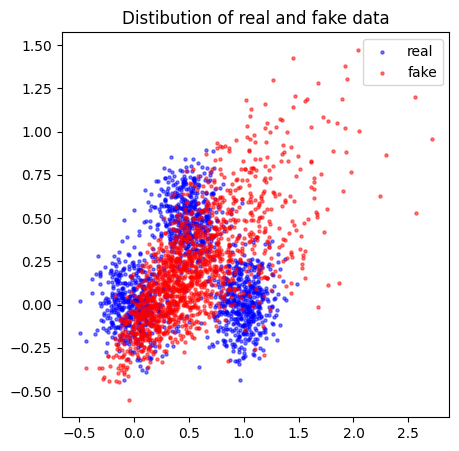


epochs = 120

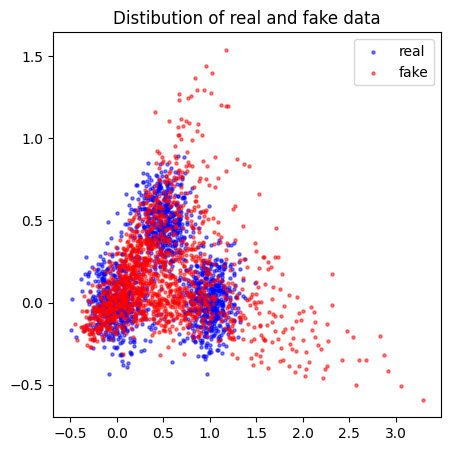


epochs = 180

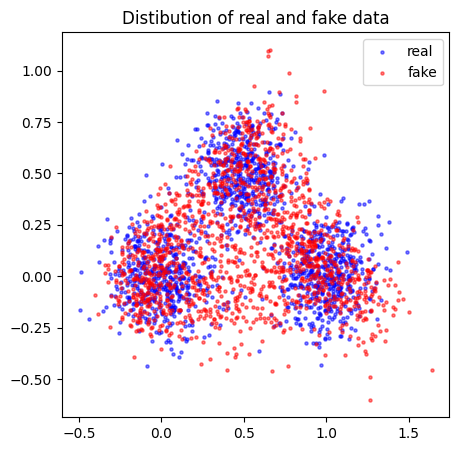


epochs = 240

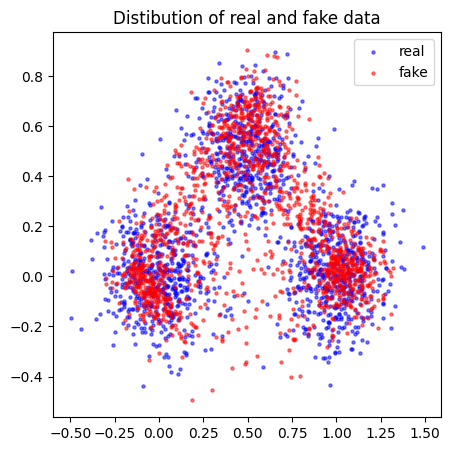


epochs = 300

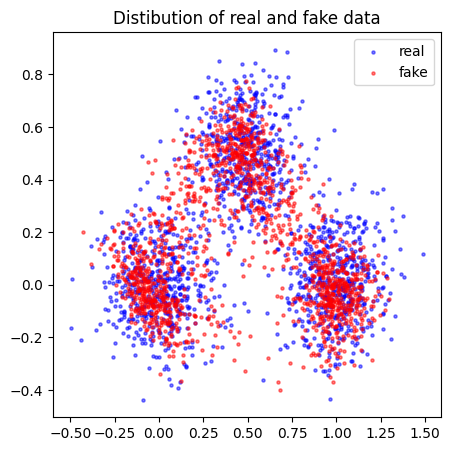

In [10]:
# Create and compile a GAN model.
model = GAN(D, G, k=1)
model.compile()

# Verify that both D*(x) and D'(G(z) converge to 0.5 
# formula:D* = p_data(x) / (p_data(x) + p_g(x))
z = np.random.uniform(-1.0, 1.0, (x_real.shape[0], nG_input))
x_fake = model.G(z).numpy()
Dx = model.D(x_real).numpy()
DGz = model.D(x_fake).numpy()
print("D*(x):"); print(Dx)
print()
print("D*(G(z)):");print(DGz)

# To observe how the G(z) changes as training progresses:
for i in range(5):
    print("\nepochs =", 60 + i * 60, end='')
    model.fit(x_real, epochs=60, batch_size=100, verbose=0)
    plot_distribution(model)